In [77]:
# library(SingleCellExperiment)
# library(scran)
# library(scater)

In [78]:
filename = "/hps/nobackup/stegle/users/acuomo/all_scripts/covid/full_counts_sce.Rds"

In [79]:
sce_all = readRDS(filename)
sce = sce_all

In [80]:
sce

class: SingleCellExperiment 
dim: 45065 141243 
metadata(0):
assays(1): counts
rownames(45065): RP11-34P13.3 FAM138A ... C11orf71.1 LINC01481.1
rowData names(0):
colnames(141243): TCTATTGCACGGTTTA-1-HCATisStab7659969_368C_Madissoon
  CATATGGTCGTCTGAA-1-HCATisStab7646034_367C_Madissoon ...
  CTCGTCAAGTAAGTAC_Donor_02_Reyfman
  TTAGGACCAGCGTTCG-1-HCATisStab7646035_367C_Madissoon
colData names(18): index age ... smoking total_counts
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [81]:
##### Note this step is hard-coded
# partial and full datasets might not and often will not be subsamples of a single sce object

In [82]:
table(sce$dataset)


   Groningen_Nawijn_2019VieiraBraga   Northwestern_Misharin_2018Reyfman 
                              11110                               41778 
         Sanger_Meyer_2019Madissoon Vanderbilt_Kropski_bioRxivHabermann 
                              56711                               31644 

In [83]:
# colData(sce)$ann_level_1 = unlist(colData(sce)$ann_level_1)
# colData(sce)$ann_level_2 = unlist(colData(sce)$ann_level_2)
# colData(sce)$ann_level_3 = unlist(colData(sce)$ann_level_3)
# colData(sce)$ann_level_4 = unlist(colData(sce)$ann_level_4)

In [84]:
# saveRDS(sce,filename)

In [85]:
# sce = readRDS(filename)

In [86]:
sce = sce[,sce$dataset == 'Sanger_Meyer_2019Madissoon']

In [87]:
sce

class: SingleCellExperiment 
dim: 45065 56711 
metadata(0):
assays(1): counts
rownames(45065): RP11-34P13.3 FAM138A ... C11orf71.1 LINC01481.1
rowData names(0):
colnames(56711): TCTATTGCACGGTTTA-1-HCATisStab7659969_368C_Madissoon
  CATATGGTCGTCTGAA-1-HCATisStab7646034_367C_Madissoon ...
  CCTTACGTCTTAACCT-1-HCATisStab7646033_367C_Madissoon
  TTAGGACCAGCGTTCG-1-HCATisStab7646035_367C_Madissoon
colData names(18): index age ... smoking total_counts
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [58]:
table(sce$sample)


 343B  356C  367C  368C  390C 
 7905 13520 13321  7186 14779 

In [59]:
samples = unique(sce$sample)
samples = samples[order(samples)]
samples

[1] "343B" "356C" "367C" "368C" "390C"

In [1]:
mydir = "/hps/nobackup/stegle/users/acuomo/all_scripts/covid/variance_dfs/"
mad_dir = paste0(mydir,"Madissoon_folder/")

In [61]:
select_genes <- function(dec,n){
    dec = dec[order(dec$mean),]
    m = min(dec$mean)
    M = max(dec$mean)
    genes = c()
    for (i in seq(m,M,length.out=n)){
        genes = c(genes,names(head(dec$mean[dec$mean>i],1)))
    }
    genes
}

In [62]:
for (sample in samples){
    sample1 = sample
    print(sample1)
    for (sample in samples){
        sample2 = sample
        if (sample1 == sample2){next}
#         print(sample2)
        sce1 = sce_all[,sce_all$sample == sample1]
        sce2 = sce_all[,sce_all$sample == sample2]
#         sce_all = sce
        sce_all1 = sce1
        sce_all2 = sce2
        celltypes1 = as.character(unique(sce1$ann_level_3))
        celltypes2 = as.character(unique(sce2$ann_level_3))
        celltypes = celltypes1[celltypes1 %in% celltypes2]
        celltypes = celltypes[!(is.na(celltypes))]
        for (celltype in celltypes){
#             print(celltype)
            sce1 = sce_all1[,sce_all1$ann_level_3 == celltype]
            sce2 = sce_all2[,sce_all2$ann_level_3 == celltype]
            if (ncol(sce1) ==1 | ncol(sce2) ==1){break}
            ## sce1
            sce = sce1
            # use edgeR to compute (log2) CPM
            logcounts(sce) = edgeR::cpm(counts(sce), log = TRUE, prior.count = 0.1)
            # compute mean variance trend (for sce1)
            dec1 <- scran::modelGeneVar(sce)
            sce1 = sce
            ## sce1
            sce = sce2
            # use edgeR to compute (log2) CPM
            logcounts(sce) = edgeR::cpm(counts(sce), log = TRUE, prior.count = 0.1)
            # compute mean variance trend (for sce2, before subsetting to only few genes)
            dec2 <- scran::modelGeneVar(sce)
            # select (10 genes) at intervals along the mean
            selected_genes = select_genes(dec2, n=11)
            ## now actually make sce2 partial
            # after saving total counts
            sce$total_counts = colSums(counts(sce))
            # select down on only present genes
            sce = sce[selected_genes,]
            assay(sce, "logcounts") <- NULL
            # re normalise (using total counts)
            logcounts(sce) = edgeR::cpm(counts(sce), log = TRUE, lib.size = sce$total_counts, prior.count = 0.1)
            sce2 = sce
            # make df to save
            df = data.frame(mean = rowMeans(logcounts(sce2)), 
                        sampled_variance = rowVars(logcounts(sce2)),
                       est_from_full_variance = metadata(dec1)$trend(rowMeans(logcounts(sce2))),
                       est_from_partial_variance_when_present = metadata(dec2)$trend(rowMeans(logcounts(sce2))))
            df$n_cells_sample1 = ncol(sce1)
            df$n_cells_sample2 = ncol(sce2)
            celltype = gsub("/","_",celltype)
            celltype = gsub(" ","_",celltype)
            filename = paste0(mad_dir,"celltype_",celltype,".full_sample_",sample1,".partial_sample_",sample2,".csv")
#             print(filename)
            write.csv(df, filename)
    
}
    }
}

[1] "343B"


Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in r

“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to uniqu

[1] "356C"


Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in r

“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to uniqu

[1] "367C"


Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in r

“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to uniqu

[1] "368C"


Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in r

“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to uniqu

[1] "390C"


Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in r

“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to uniqu

In [2]:
myfiles = list.files(mad_dir)
length(myfiles)

[1] 280

In [65]:
make_plotting_df <- function(df){
    df0 = df[,c("mean","sampled_variance")]
    colnames(df0) <- c("mean","variance")
    df0$type = 'sample_variance_sample2'
    df1 = df[,c("mean","est_from_full_variance")]
    colnames(df1) <- c("mean","variance")
    df1$type = 'var_estimated_from_mean_var_trend_from_sample1'
    df2 = df[,c("mean","est_from_partial_variance_when_present")]
    colnames(df2) <- c("mean","variance")
    df2$type = 'var_estimated_from_mean_var_trend_from_sample2'
    rbind(df0,df1,df2)
}

In [66]:
# options(repr.plot.width = 8, repr.plot.height = 3)
# for (file in myfiles){
#     celltype = gsub("\\.full.*","",gsub("celltype_","",file))
#     sample1 = gsub(".*\\.full_","",gsub("\\.partial_sample_.*","",file))
#     sample2 = gsub(".*\\.partial_","",gsub(".csv","",file))
#     filename = paste0(mad_dir,file)
#     df = read.csv(filename, row.names = 1)
#     plotting_df = make_plotting_df(df)
#     p = ggplot(plotting_df, aes(x = mean, y = variance, col = type)) + geom_point() + theme_bw()
#     print(p + ggtitle(paste0(sample1,", ",sample2,", ",celltype)))
# }

In [68]:
get_distance_from_df <- function(df){
    df$dist = abs(df$sampled_variance-df$est_from_full_variance)
    mean(df$dist)
}

In [69]:
dist_df = data.frame()

for (file in myfiles){
    celltype = gsub("\\.full.*","",gsub("celltype_","",file))
    sample1 = gsub(".*\\.full_","",gsub("\\.partial_sample_.*","",file))
    sample2 = gsub(".*\\.partial_","",gsub(".csv","",file))
    filename = paste0(mad_dir,file)
    df = read.csv(filename, row.names = 1)
    dist = get_distance_from_df(df)
    dist_df = rbind(dist_df, data.frame(sample1 = sample1, sample2 = sample2, celltype = celltype, 
                                        avg_distance = dist, n_genes = nrow(df), 
                                        ncells_sample1 = df$n_cells_sample1[1], 
                                        ncells_sample2 = df$n_cells_sample2[1]))
}

In [71]:
head(dist_df)

sample1,sample2,celltype,avg_distance,n_genes,ncells_sample1,ncells_sample2
sample_343B,sample_356C,2_Blood_vessels,1.255595,10,830,150
sample_343B,sample_367C,2_Blood_vessels,1.243280,10,830,831
sample_343B,sample_368C,2_Blood_vessels,1.826676,10,830,388
sample_343B,sample_390C,2_Blood_vessels,1.766272,10,830,425
sample_356C,sample_343B,2_Blood_vessels,1.478029,10,150,830
sample_356C,sample_367C,2_Blood_vessels,1.066452,10,150,831


In [72]:
library(ggplot2)

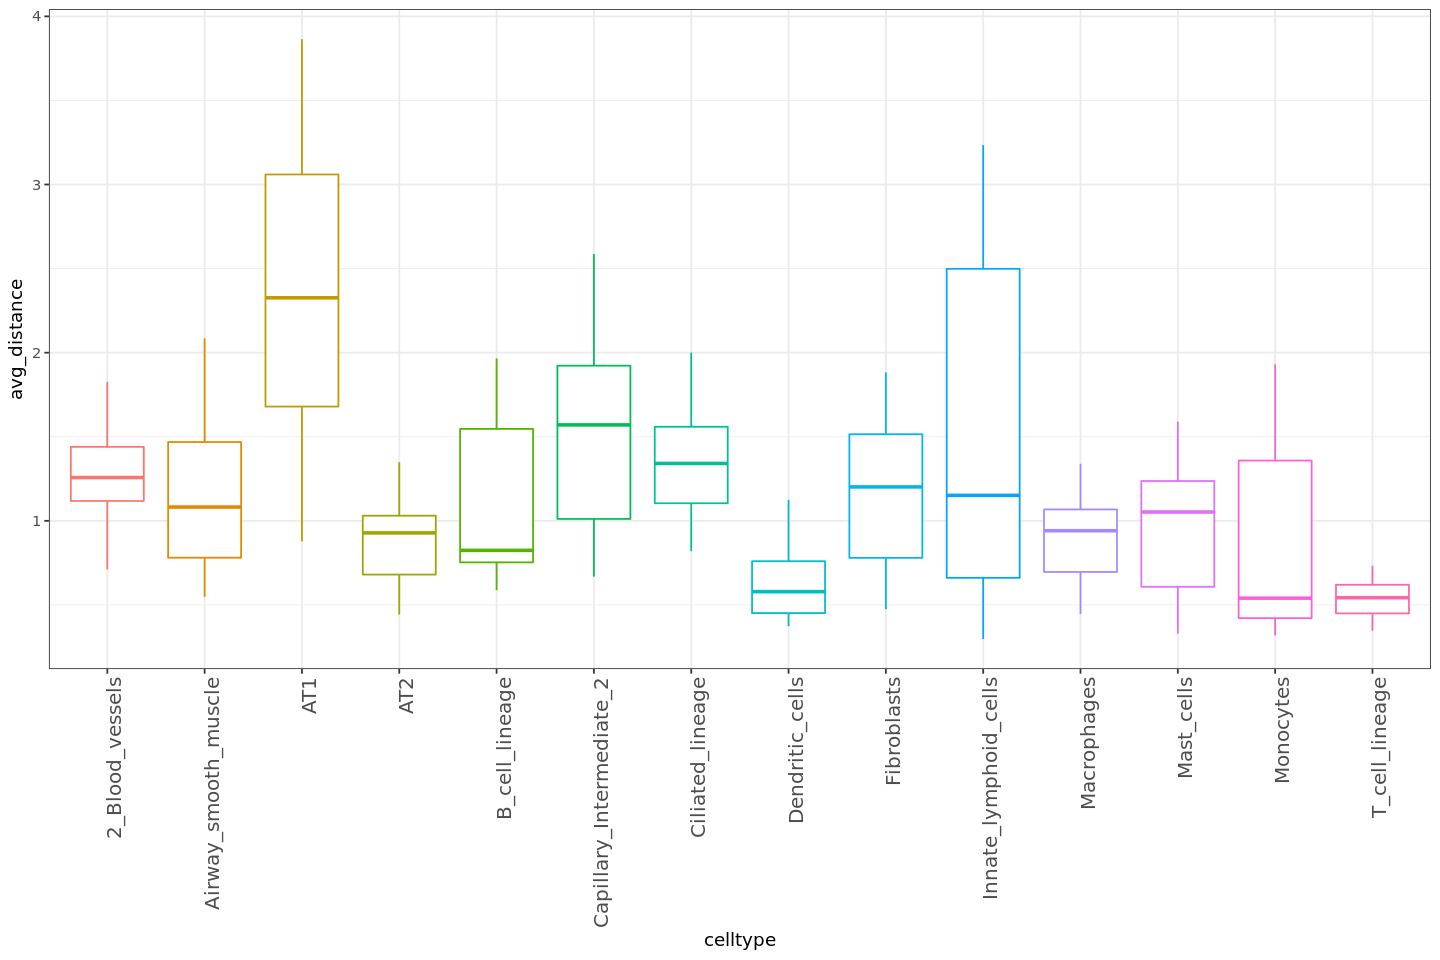

In [73]:
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(dist_df, aes(x = celltype, y = avg_distance, colour = celltype)) + geom_boxplot() + theme_bw() +
    theme(legend.position = "none", axis.text.x = element_text(angle = 90, hjust = 1, size = 12))

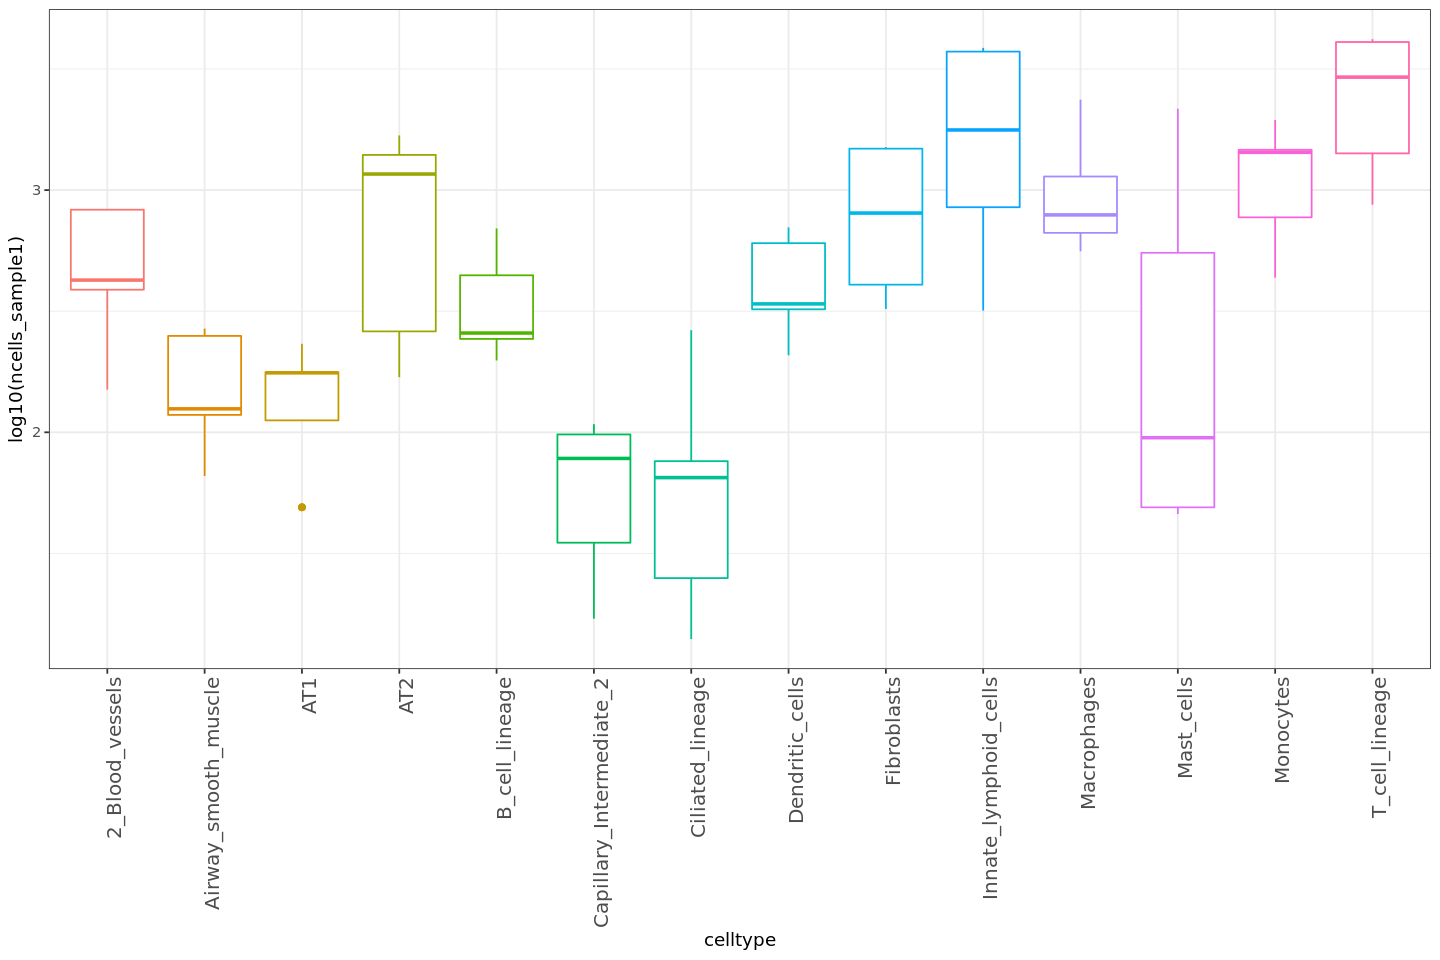

In [74]:
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(dist_df, aes(x = celltype, y = log10(ncells_sample1), colour = celltype)) + geom_boxplot() + theme_bw() +
    theme(legend.position = "none", axis.text.x = element_text(angle = 90, hjust = 1, size = 12))

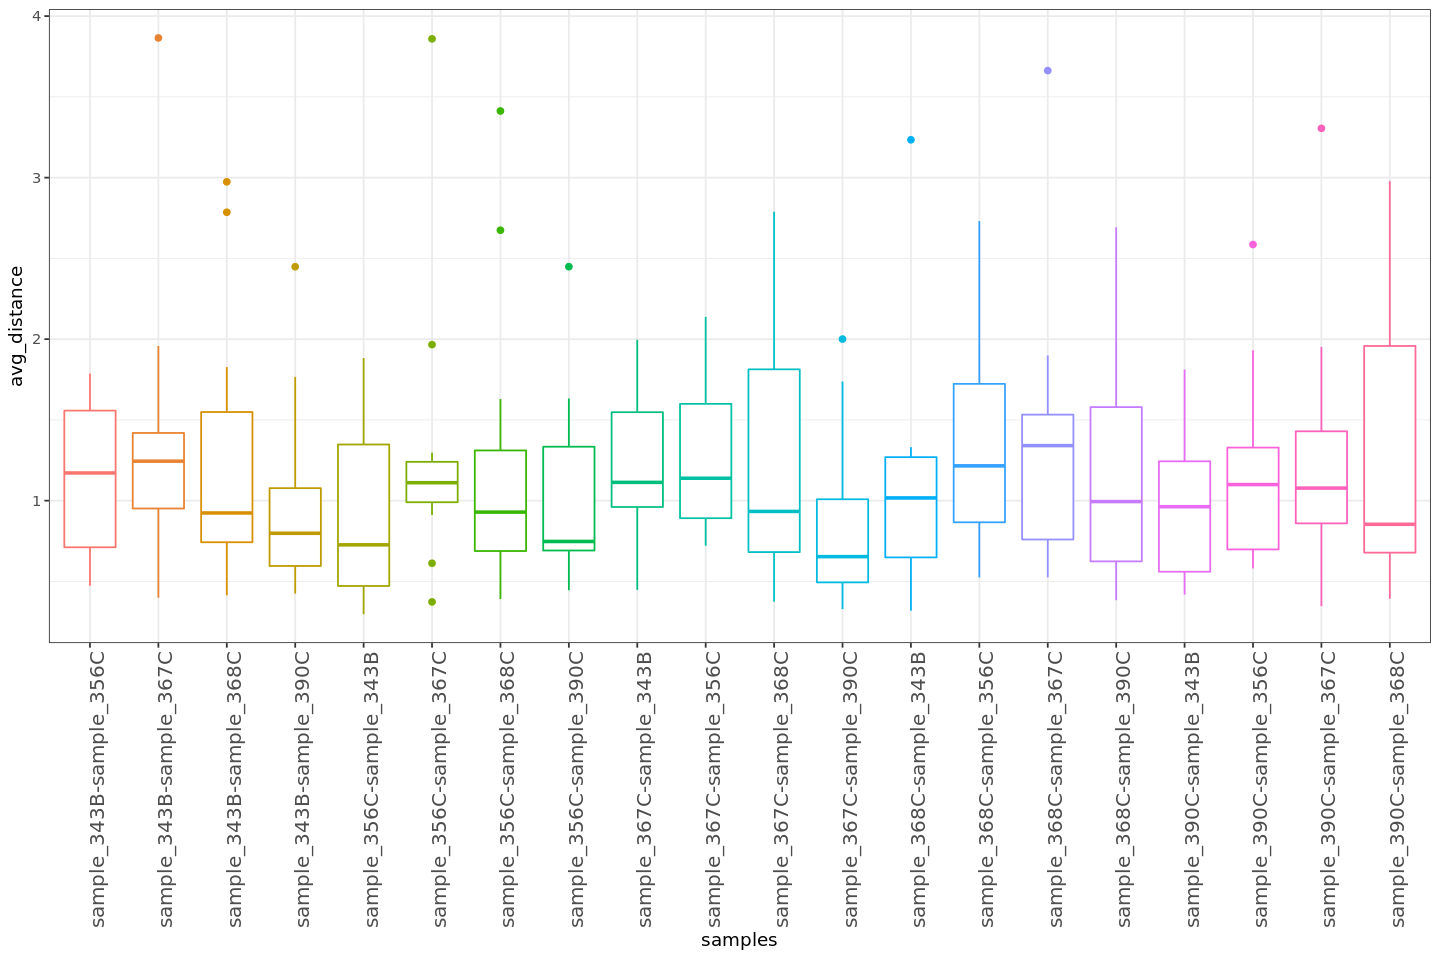

In [75]:
options(repr.plot.width = 12, repr.plot.height = 8)
dist_df$samples = paste0(dist_df$sample1,"-",dist_df$sample2)
ggplot(dist_df, aes(x = samples, y = avg_distance, colour = samples)) + geom_boxplot() + theme_bw() +
    theme(legend.position = "none", axis.text.x = element_text(angle = 90, hjust = 1, size = 12))

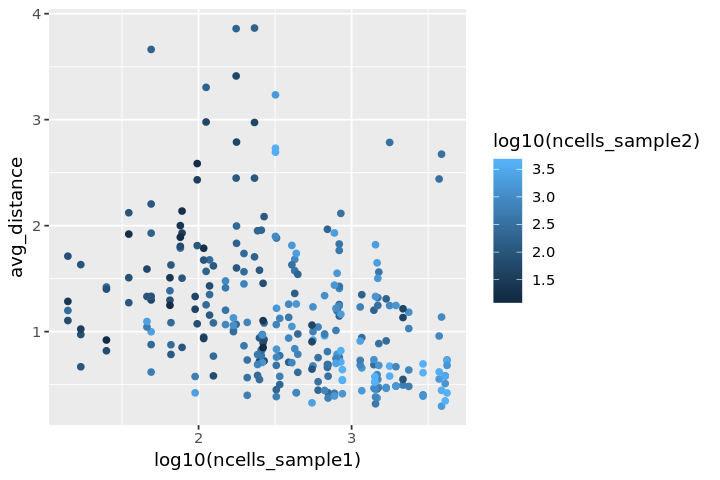

In [76]:
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(dist_df, aes(x = log10(ncells_sample1), y = avg_distance, colour = log10(ncells_sample2))) + geom_point()